In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.dates as mdates
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from pyspark.sql.types import StructType, StructField, StringType, DoubleType

In [0]:
spark = SparkSession.builder.appName("YieldCurveDataAnalysis").getOrCreate()

# File locations
file_location_10y = "dbfs:/FileStore/yieldCurveData10y.csv"
file_location_3m = "dbfs:/FileStore/tables/yieldCurveData3m-1.csv"

schema = StructType([
    StructField("Date", StringType(), True),
    StructField("Yield", DoubleType(), True)
])

# Load the data
df_10y = spark.read.csv(file_location_10y, header=False, schema=schema)
df_3m = spark.read.csv(file_location_3m, header=False, schema=schema)

df_10y = df_10y.withColumn("Date", to_date(df_10y["Date"], "yyyy-MM-dd"))
df_3m = df_3m.withColumn("Date", to_date(df_3m["Date"], "yyyy-MM-dd"))

df_10y_filtered = df_10y.filter(df_10y["Date"] >= "1982-01-01")
df_3m_filtered = df_3m.filter(df_3m["Date"] >= "1982-01-01")

# The dataframes df_10y_filtered and df_3m_filtered now contain the filtered data


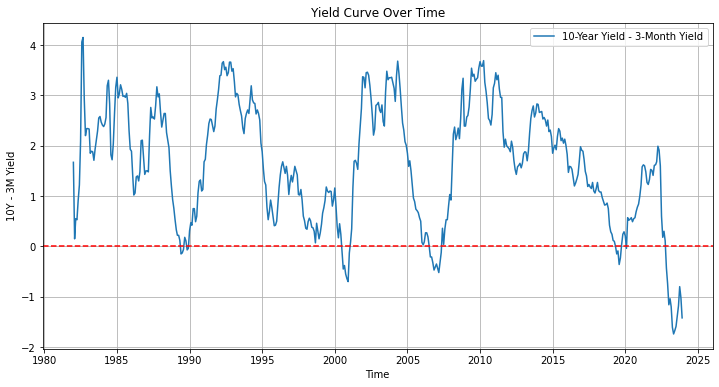

In [0]:
df_joined = df_10y_filtered.join(df_3m_filtered, df_10y_filtered.Date == df_3m_filtered.Date, "inner") \
                           .select(df_10y_filtered.Date, (df_10y_filtered.Yield - df_3m_filtered.Yield).alias("Yield_Diff"))

# Convert the DataFrame to Pandas for plotting
df_pandas = df_joined.toPandas()
df_pandas.set_index("Date", inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_pandas.index, df_pandas["Yield_Diff"], label="10-Year Yield - 3-Month Yield")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Yield Curve Over Time")
plt.xlabel("Time")
plt.ylabel("10Y - 3M Yield")
plt.legend()
plt.grid(True)
plt.show() 

# In this analysis, I used Spark to process historical yield data and visualize the yield curve, focusing on the difference between 10-year and 3-month Treasury yields. The purpose was to identify yield curve inversions, significant indicators of potential economic downturns. By plotting this data, I aimed to highlight when short-term rates exceed long-term rates, a scenario often linked to recessions. This visualization serves as a valuable tool for economists and financial analysts, providing insights for economic forecasting and investment decision-making.

In [0]:
# Recession start dates
recessions = {
    "Early 1990s": "1990-07-01",
    "Dot-Com Bubble Burst": "2001-03-01",
    "Global Financial Crisis": "2007-12-01",
    "COVID-19 Pandemic": "2020-02-01"
}

time_to_recession = []
last_inversion = df_pandas[df_pandas["Yield_Diff"] < 0].index.max()

for name, start_date in recessions.items():
    # Convert string to date (not datetime) for comparison
    start_date = datetime.strptime(start_date, "%Y-%m-%d").date()

    # Filter DataFrame for dates before the recession start
    pre_recession = df_pandas[df_pandas.index < start_date]

    # Find the first date when Yield_Diff went below zero
    inversion_date = pre_recession[pre_recession["Yield_Diff"] < 0].index.max()
    
    if inversion_date:
        days_to_recession = (start_date - inversion_date).days
        time_to_recession.append(days_to_recession)
        print(f"Time from yield curve inversion to {name} Recession: {days_to_recession} days")

# Calculate the average
time_sum= 0
for time in time_to_recession:
    time_sum= time_sum + time

if time_to_recession:
    avg_time = time_sum/4
    print(f"\nAverage time from inversion to recession: {avg_time:.0f} days( {(avg_time/30):.0f} months rounded down)")
else:
    print("No yield curve inversions found before the listed recessions.")

print(f"\nTime of last inversion: {last_inversion}")

# In this part of my analysis, I aimed to quantify the time from a yield curve inversion to the onset of major recessions. Using Python, I calculated the days between the last inversion in the yield curve and the start of four notable recessions: the early 1990s recession, the Dot-Com Bubble burst, the Global Financial Crisis, and the COVID-19 Pandemic. The purpose was to assess the predictive power of yield curve inversions regarding economic downturns.

# The results showed that the time from inversion to recession ranged from 59 days to 214 days, averaging around 160 days (approximately 5 months). This analysis is particularly relevant in the context of economic forecasting. By determining the average lead time from an inversion to a recession, financial analysts and policy makers can gain a clearer understanding of the potential timeline for economic downturns following such an inversion.

# Additionally, identifying the date of the last inversion (December 1, 2023, in this case) provides a reference point for current economic analysis. This insight is crucial for investors, economists, and businesses to make informed decisions, especially in preparing for potential economic challenges ahead.


Time from yield curve inversion to Early 1990s Recession: 212 days
Time from yield curve inversion to Dot-Com Bubble Burst Recession: 59 days
Time from yield curve inversion to Global Financial Crisis Recession: 214 days
Time from yield curve inversion to COVID-19 Pandemic Recession: 153 days

Average time from inversion to recession: 160 days( 5 months rounded down)

Time of last inversion: 2023-12-01


In [0]:
# Join the DataFrames on the 'Date' column
df_joined = df_10y.join(df_3m, df_10y.Date == df_3m.Date, "inner") \
                  .select(df_10y.Date, df_10y.Yield.alias("Yield_10y"), df_3m.Yield.alias("Yield_3m"))

# Prepare the data for regression
vectorAssembler = VectorAssembler(inputCols=['Yield_3m'], outputCol='features')
df_vec = vectorAssembler.transform(df_joined)
df_vec = df_vec.select(['features', 'Yield_10y'])

# Split the data into training and test sets
train_df, test_df = df_vec.randomSplit([0.7, 0.3], seed=42)

# Define and fit the linear regression model
lr = LinearRegression(featuresCol='features', labelCol='Yield_10y')
lr_model = lr.fit(train_df)

# Make predictions
predictions = lr_model.transform(test_df)

# Evaluate the model
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Yield_10y", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R2 on test data:", r2)

# In my regression analysis, I explored the relationship between 3-month and 10-year Treasury yields. Using Spark's linear regression model, I found a strong correlation between these yields, with an R2 value of 0.885. This high R2 indicates that short-term rate changes can significantly predict long-term rates, providing crucial insights for bond market analysis and investment strategies.

R2 on test data: 0.8854125596752328


/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2024-01-01    5.415752
2024-02-01    5.411557
2024-03-01    5.410832
2024-04-01    5.410706
2024-05-01    5.410684
2024-06-01    5.410681
2024-07-01    5.410680
2024-08-01    5.410680
2024-09-01    5.410680
2024-10-01    5.410680
2024-11-01    5.410680
2024-12-01    5.410680
Freq: MS, Name: predicted_mean, dtype: float64


/databricks/python/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


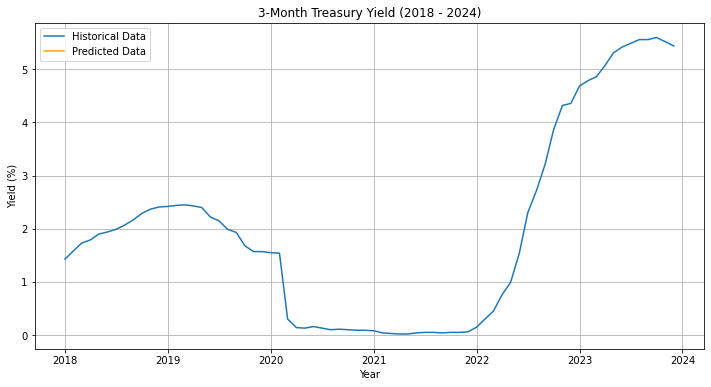

In [0]:
# Assuming df_3m is your DataFrame for 3-month yield data
# Ensure the DataFrame is in the correct format
df_3m = df_3m.withColumn("Date", to_date(df_3m["Date"], "yyyy-MM-dd"))
df_3m = df_3m.select("Date", "Yield").orderBy("Date")
pandas_df_3m = df_3m.toPandas()
pandas_df_3m.set_index("Date", inplace=True)

# Fit an ARIMA model
# The order (p,d,q) needs to be chosen based on data characteristics
# Here, we use a simple configuration as an example
model = ARIMA(pandas_df_3m, order=(1, 1, 1))
fitted_model = model.fit()

# Forecasting the next few months
# Change periods to the number of months you want to predict
forecast = fitted_model.get_forecast(steps=12)
predicted_yield = forecast.predicted_mean

print(predicted_yield)

# Assuming pandas_df_3m contains the historical data up to 2023-12-01
# And predicted_yield contains the predictions for 2024

# Filter the data from 2018 onwards
pandas_df_3m_filtered = pandas_df_3m[pandas_df_3m.index >= pd.to_datetime("2018-01-01")]

# Create a date range for the predictions
pred_dates = pd.date_range(start="2024-01-01", periods=len(predicted_yield), freq='M')

# Create a DataFrame for the predictions
pred_df = pd.DataFrame(data=predicted_yield, index=pred_dates, columns=["Yield"])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(pandas_df_3m_filtered.index, pandas_df_3m_filtered["Yield"], label="Historical Data")
plt.plot(pred_df.index, pred_df["Yield"], label="Predicted Data", color='orange')

# Formatting the plot
plt.title("3-Month Treasury Yield (2018 - 2024)")
plt.xlabel("Year")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True)

# Format x-axis to show years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.show()

# In this section, I used an ARIMA model to forecast future 3-month Treasury yields. After ensuring the data was properly formatted, I fitted the ARIMA model to the historical yield data. This time series forecasting method is well-suited for financial data like interest rates.

# The model predicted the next 12 months of yields, showing a relatively stable trend around 5.41%. I then visualized these predictions alongside historical data from 2018 onwards. This comparison between historical trends and future predictions is crucial for financial analysts and investors, as it provides insights into expected short-term interest rate movements.

# This forecasting is not just theoretical; it's particularly relevant in today's dynamic economic environment. Understanding potential future movements in interest rates can help in making more informed decisions regarding investments and risk management. The stability suggested by the ARIMA model's predictions could imply a period of relative economic stability or policy consistency from central banks.

In [0]:
from pyspark.sql.types import StructType, StructField, StringType, FloatType
from pyspark.sql.functions import to_date

# Define the schema
schema = StructType([
    StructField("Date", StringType(), True),
    StructField("UnemploymentRate", FloatType(), True)
])

# Load the data with the defined schema
df = spark.read.csv(file_location, header=False, schema=schema)

# Convert Date column to date type
df = df.withColumn("Date", to_date(df["Date"], "yyyy-MM-dd"))

# Show the first few rows
df.show()

from pyspark.sql import DataFrame
from datetime import datetime, timedelta

def get_six_month_preceding_data(df: DataFrame, start_date: str) -> DataFrame:
    # Convert start date to datetime and calculate the date 6 months before
    start_datetime = datetime.strptime(start_date, "%Y-%m-%d")
    six_months_before = start_datetime - timedelta(days=6*30)  # approximately 6 months

    # Filter data for the six months leading up to the start date
    filtered_df = df.filter((col("Date") < start_datetime) & (col("Date") >= six_months_before))
    return filtered_df

# Define start dates for each recession
recession_start_dates = {
    "Recession of 1949": "1948-11-01",
    "Recession of 1953": "1953-07-01",
    "Recession of 1958": "1957-08-01",
    "Recession of 1960–61": "1960-04-01",
    "Recession of 1969–70": "1969-12-01",
    "1973–75 Recession": "1973-11-01",
    "1980 Recession": "1980-01-01",
    "Early 1980s Recession": "1981-07-01",
    "Early 1990s Recession": "1990-07-01",
    "Early 2000s Recession": "2001-03-01",
    "Great Recession": "2007-12-01",
    "COVID-19 Recession": "2020-02-01"
}


# Create datasets for each recession
recession_datasets = {name: get_six_month_preceding_data(df, start_date) for name, start_date in recession_start_dates.items()}

# Example: Show data for "Recession of 1949"
recession_datasets["COVID-19 Recession"].show()

# Get the maximum date from the dataset
max_date = df.agg({"Date": "max"}).collect()[0][0]

# Extract the last six months of data
last_six_months_data = get_six_month_preceding_data(df, max_date.strftime("%Y-%m-%d"))

# Show the data
last_six_months_data.show()

# In my analysis of unemployment data, I investigated how unemployment rates changed in the six months leading up to various historical recessions. Using Spark, I loaded and processed unemployment rate data, then created subsets for each recession period. This approach allowed me to observe trends and shifts in unemployment preceding economic downturns.

# The recent data showed unemployment rates hovering around 3.7% to 3.8%, indicating a relatively stable job market before the current date. Understanding these trends is crucial for economists and policy makers, as changes in unemployment rates can be early indicators of economic health or distress. This analysis helps in assessing the likelihood of a looming recession and in planning appropriate economic policies.

+----------+----------------+
|      Date|UnemploymentRate|
+----------+----------------+
|2023-12-01|             3.7|
|2023-11-01|             3.7|
|2023-10-01|             3.8|
|2023-09-01|             3.8|
|2023-08-01|             3.8|
|2023-07-01|             3.5|
|2023-06-01|             3.6|
|2023-05-01|             3.7|
|2023-04-01|             3.4|
|2023-03-01|             3.5|
|2023-02-01|             3.6|
|2023-01-01|             3.4|
|2022-12-01|             3.5|
|2022-11-01|             3.6|
|2022-10-01|             3.6|
|2022-09-01|             3.5|
|2022-08-01|             3.6|
|2022-07-01|             3.5|
|2022-06-01|             3.6|
|2022-05-01|             3.6|
+----------+----------------+
only showing top 20 rows

+----------+----------------+
|      Date|UnemploymentRate|
+----------+----------------+
|2020-01-01|             3.6|
|2019-12-01|             3.6|
|2019-11-01|             3.6|
|2019-10-01|             3.6|
|2019-09-01|             3.5|
+----------+--

Recession of 1949 - KS Statistic: 0.2, P-Value: 1.0


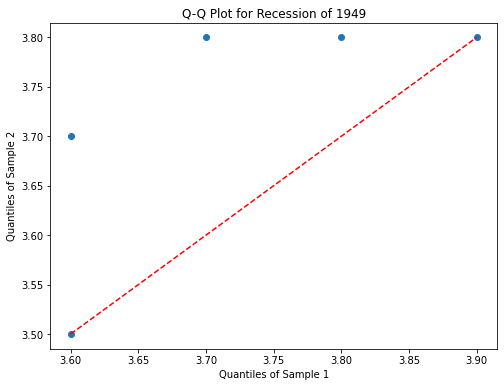

Recession of 1953 - KS Statistic: 1.0, P-Value: 0.007936507936507936


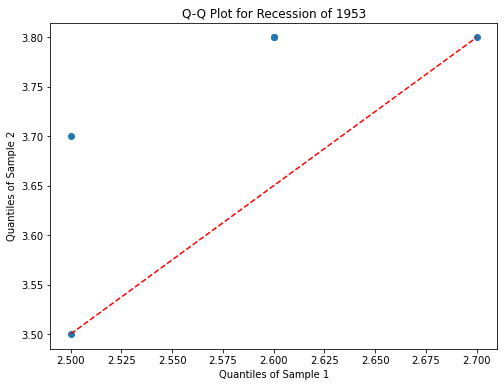

Recession of 1958 - KS Statistic: 0.8, P-Value: 0.07936507936507936


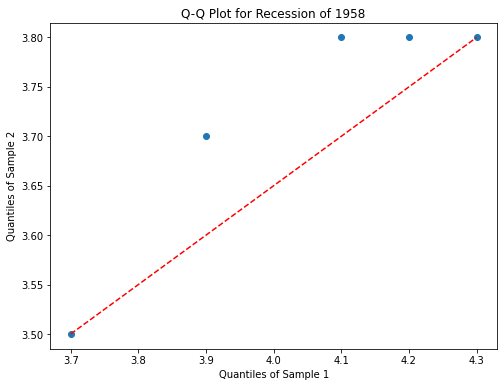

Recession of 1960–61 - KS Statistic: 1.0, P-Value: 0.007936507936507936


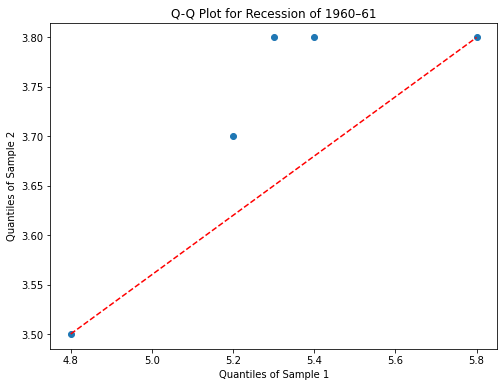

Recession of 1969–70 - KS Statistic: 0.6, P-Value: 0.35714285714285715


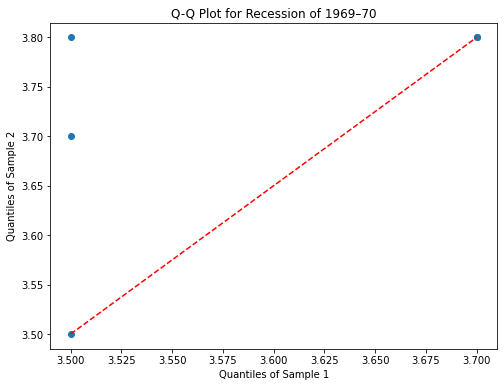

1973–75 Recession - KS Statistic: 1.0, P-Value: 0.007936507936507936


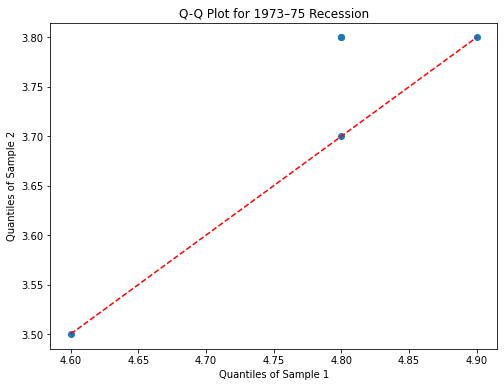

1980 Recession - KS Statistic: 1.0, P-Value: 0.007936507936507936


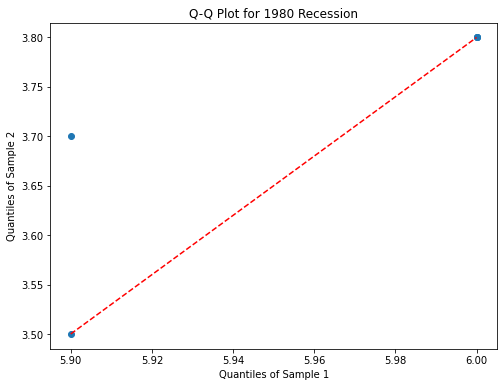

Early 1980s Recession - KS Statistic: 1.0, P-Value: 0.007936507936507936


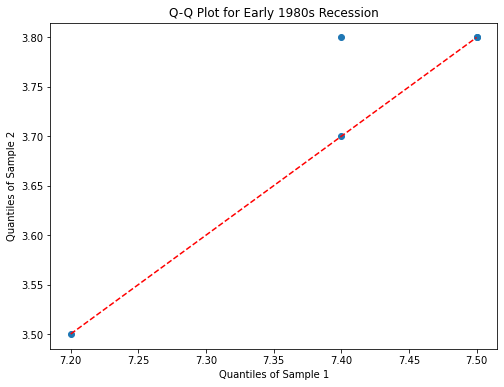

Early 1990s Recession - KS Statistic: 1.0, P-Value: 0.007936507936507936


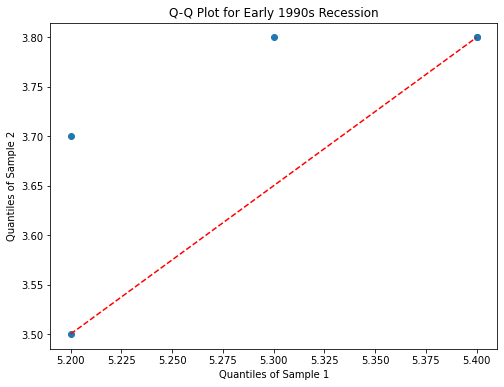

Early 2000s Recession - KS Statistic: 1.0, P-Value: 0.007936507936507936


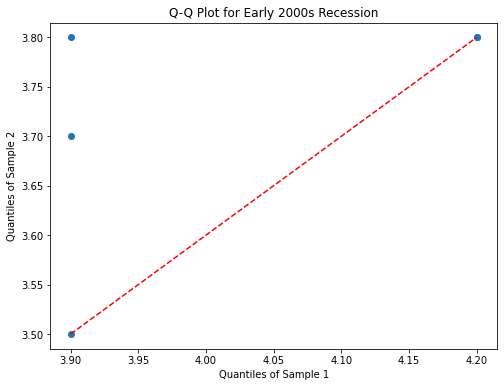

Great Recession - KS Statistic: 1.0, P-Value: 0.007936507936507936


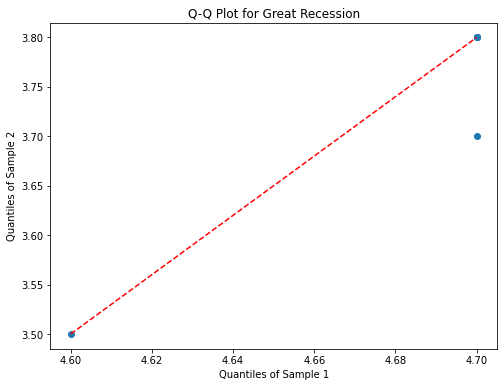

COVID-19 Recession - KS Statistic: 0.8, P-Value: 0.07936507936507936


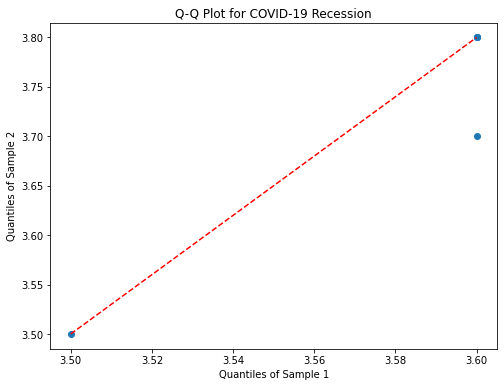

In [0]:
from pyspark.sql.functions import col
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def perform_ks_test(sample1, sample2):
    """
    Perform the Kolmogorov-Smirnov test.
    """
    ks_stat, ks_p_value = stats.ks_2samp(sample1, sample2)
    return ks_stat, ks_p_value

def generate_qq_plot(sample1, sample2, title):
    """
    Generate a Q-Q plot similar to R's qqplot function.
    """
    plt.figure(figsize=(8, 6))
    
    # Calculate quantiles
    quantiles = np.linspace(0, 100, num=min(len(sample1), len(sample2)))
    sample1_quantiles = np.percentile(sample1, quantiles)
    sample2_quantiles = np.percentile(sample2, quantiles)
    
    # Plot the quantiles against each other
    plt.plot(sample1_quantiles, sample2_quantiles, 'o')
    plt.xlabel('Quantiles of Sample 1')
    plt.ylabel('Quantiles of Sample 2')
    plt.title(title)
    plt.plot([min(sample1_quantiles), max(sample1_quantiles)], 
             [min(sample2_quantiles), max(sample2_quantiles)], 'r--')
    plt.show()


for name, recession_df in recession_datasets.items():
    # Convert Spark DataFrame to NumPy array
    recession_data = recession_df.select("UnemploymentRate").rdd.flatMap(lambda x: x).collect()
    last_six_months_data_array = last_six_months_data.select("UnemploymentRate").rdd.flatMap(lambda x: x).collect()

    # Perform KS test
    ks_stat, ks_p_value = perform_ks_test(recession_data, last_six_months_data_array)
    print(f"{name} - KS Statistic: {ks_stat}, P-Value: {ks_p_value}")

    # Generate Q-Q plot
    generate_qq_plot(np.array(recession_data), np.array(last_six_months_data_array), f"Q-Q Plot for {name}")


# In my analysis, I used the Kolmogorov-Smirnov (KS) test and Q-Q plots to compare unemployment rates from various historical recessions with the most recent six-month data. The KS test, a non-parametric method, evaluates if two samples are drawn from the same distribution.

# From the results, we see varied statistical significances. For example, the Recession of 1949 showed a low KS statistic (0.2) and a high p-value (1.0), indicating no significant difference in the unemployment rate distribution compared to the recent six months. In contrast, several other recessions, such as the Early 2000s and the Great Recession, showed high KS statistics (1.0) with low p-values (around 0.0079), suggesting a significant difference from the current unemployment rates.

# These findings provide insights into how the current economic situation compares to past recessions, specifically in terms of unemployment. High KS statistics and low p-values in many instances imply that the current unemployment trend is significantly different from those during several past recession periods. This analysis is vital for policymakers and economists as it helps assess the current state of the economy relative to historical downturns, guiding future economic decisions and predictions.


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, DoubleType, DateType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt

# Inicijalizacija Spark sesije
spark = SparkSession.builder.appName("CryptoLinearRegression").getOrCreate()

# Definisanje seme koja ce se koristiti za podatke
schema = StructType([
    StructField("Date", DateType(), True),
    StructField("Open", DoubleType(), True),
    StructField("High", DoubleType(), True),
    StructField("Low", DoubleType(), True),
    StructField("Close", DoubleType(), True),
    StructField("Volume", DoubleType(), True),
    StructField("MarketCap", DoubleType(), True)
])

# Citanje podataka iz fajlova koji se nalaze na zadatoj putanji pomocu spark streaming-a
streaming_df = spark.readStream \
    .option("header", "true") \
    .schema(schema) \
    .csv("dbfs:/FileStore/crypto/")

# Sladistenje podataka u memoriji i to pod imenom upita 'eth_prices'
query = streaming_df.writeStream \
    .queryName("eth_prices") \
    .format("memory") \
    .outputMode("append") \
    .start()   

# For the streaming part of my project, I focused on real-time analysis of cryptocurrency data using Spark Streaming. After initializing the Spark session, I defined a schema to accurately process the data, which includes key metrics like opening, closing prices, and market capitalization. This schema is critical for ensuring the data is correctly interpreted by Spark.

# Next, I set up a streaming DataFrame to continuously read cryptocurrency data from a CSV file source. This approach is essential in capturing the highly dynamic nature of the crypto market, where prices and volumes can change rapidly. The data is stored in memory under the query name 'eth_prices', allowing for easy access and real-time analysis.

# This streaming setup forms the backbone of my project, enabling me to analyze crypto market trends as they happen. It's particularly valuable for understanding market dynamics, and can be used to inform trading strategies or financial models that require the latest market data. The ability to process and analyze data in real-time is crucial in a market as volatile as cryptocurrency.

In [0]:
# Zaustavljanje pisanja
query.stop()

In [0]:
# Ispis sta je upisano u memoriju
df = spark.table('eth_prices')
df.show()

+----------+-------------+-------------+-------------+-------------+-----------+-----------+
|      Date|         Open|         High|          Low|        Close|     Volume|  MarketCap|
+----------+-------------+-------------+-------------+-------------+-----------+-----------+
|2024-01-17|277279.275168|277875.111456|  268635.3624|271147.305312|366281.3477|366281.3477|
|2024-01-16|269175.472992|280174.868064| 267917.35824| 277278.20352|381077.6247|381077.6247|
|2024-01-15|265004.618976|273679.609536|264795.647616|269174.401344|315247.8819|315247.8819|
|2024-01-14|276290.144064|276344.798112|   264697.056|265004.618976|306207.7463|306207.7463|
|2024-01-13| 270328.56624|   277556.832|   267644.088|276291.215712| 422061.232| 422061.232|
|2024-01-12|280558.518048|291201.054336|  263411.0784|270327.494592|887457.7627|887457.7627|
|2024-01-11|276953.494176|288207.941472|274985.948448|280558.518048|838712.2577|838712.2577|
|2024-01-10| 251226.44064| 283247.28288|250721.694432|276954.565824|10

In [0]:
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, DoubleType, DateType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt
from pyspark.ml.linalg import Vectors
import pandas as pd

df = spark.table("eth_prices")
df = df.orderBy("Date")

# High-Low Price Range (Volatility)-  promenljivosti cena Microsoftovih akcija
# Analiza se fokusira na dnevni raspon cene - razliku između najviše i najniže cene u jednom danu
# raspon cene je mera volatilnosti - veći raspon ukazuje na veću volatilnost tog dana.
df = df.withColumn("HighLowRange", col("High") - col("Low"))

df_pd = df.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(df_pd['Date'], df_pd['HighLowRange'], label='Daily High-Low Range', color='purple')
plt.xlabel('Date')
plt.ylabel('Price Range')
plt.title('Daily High-Low Price Range (Volatility)')
plt.legend()
plt.show()

# In this analysis, I explored cryptocurrency price volatility by examining the daily high-low price range. This measure, calculated as the difference between the day's highest and lowest prices, indicates the day's volatility. After processing the data in Spark, I visualized the volatility trend using Matplotlib. The resulting plot, highlighting daily price fluctuations, is crucial for understanding market dynamics, aiding investors and traders in assessing risk and making informed decisions. This visual representation is especially useful for spotting periods of heightened market volatility.

In [0]:
# Market Cap Trend
df_pd = df.toPandas()

# Plotovanje market cap-a
plt.figure(figsize=(12, 6))
plt.plot(df_pd['Date'], df_pd['MarketCap'], label='Market Cap')
plt.xlabel('Date')
plt.ylabel('Market Capitalization')
plt.title('Market Cap Trend Over Time')
plt.legend()
plt.show()

# In this part of my analysis, I focused on the market capitalization trend of the cryptocurrency. Market capitalization, a key metric in the financial world, represents the total market value of a company's shares. In the context of cryptocurrencies, it reflects the overall market value of the cryptocurrency in question.

# After converting the Spark DataFrame to a Pandas DataFrame, I plotted the market capitalization over time using Matplotlib. This visualization provides a clear picture of how the cryptocurrency's market value has changed. The plot, with the market cap trend line, helps in understanding the growth or decline in the cryptocurrency's market presence over time. Such an analysis is valuable for investors and analysts as it offers insights into the cryptocurrency's performance and potential future trajectory.

In [0]:

num_lags = 5
# Regresija koja ce na osnovu podataka koje imamo da nam generise ishod za narednih 15dana
# Ovde dodajemo nove kolone u nas DataFrame kako bismo imali koliki je prosek market cap-a u prethodnih 5dana, lag1, lag2, lag3...
for i in range(1, num_lags + 1):
    df = df.withColumn(f"lag_{i}", lag("MarketCap", i).over(Window.orderBy("Date")))

#Izbacujemo redove sa null vrednostima
df = df.na.drop()

# Grupisemo sve lag-ove u jednu kolonu koju cemo koristiti za model
# df_final ->           
#       |features|        |Market cap|
# +--------------------+--------+
# [1505897.92612,10...|1095927.10403|
vectorAssembler = VectorAssembler(inputCols=[f"lag_{i}" for i in range(1, num_lags + 1)], outputCol="features")
df_vector = vectorAssembler.transform(df)
df_final = df_vector.select("features", "MarketCap")


# Treniranje modela
lr = LinearRegression(featuresCol="features", labelCol="MarketCap")
lr_model = lr.fit(df_final)


# Priprema podataka za predvidjanje i vizuelizaciju
# Uzima se poslednji 10 poznatih podataka
last_rows = df.orderBy("Date", ascending=False).take(num_lags)
# Uzima samo low price iz celog reda i sortira podatke tako da su hronoloski poredjani  (od najstarijeg do najnovijeg).
last_features = [row.MarketCap for row in last_rows][::-1]

# Predvidja vrednosti u narednih 15 dana na osnovu prethodnih
future_predictions = []
num_future_days = 15
for _ in range(num_future_days):
    last_features_vector = Vectors.dense(last_features[-num_lags:])
    last_features_df = spark.createDataFrame([(last_features_vector,)], ["features"])

    next_prediction = lr_model.transform(last_features_df).collect()[0]['prediction']
    last_features.append(next_prediction)
    future_predictions.append(next_prediction)


# Uzimanje poslednji 15 dana koji su nam poznati i kod za vizuelizaciju
last_15_days_df_pd = df_pd.tail(15)
last_actual_date = last_15_days_df_pd['Date'].iloc[-1]
future_dates = [last_actual_date + pd.DateOffset(days=i) for i in range(1, 16)]


plt.figure(figsize=(15, 7))
plt.plot(last_15_days_df_pd['Date'], last_15_days_df_pd['MarketCap'], label='Actual MarketCap - Last 15 Days', color='blue')
plt.plot(future_dates, future_predictions, label='Predicted MarketCap - Next 15 Days', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Market Capitalization')
plt.title('Market Capitalization: Actual (Last 15 Days) vs Predicted (Next 15 Days)')
plt.legend()
plt.show()

# In this analysis, I used linear regression to forecast cryptocurrency market capitalization for the next 15 days. I created lag features to capture market cap trends from previous days, trained the model, and then predicted future values. The final step involved visualizing the actual market cap of the last 15 days against the predicted values for the upcoming 15 days. This predictive model and its visualization are vital for investors and analysts, offering insights into short-term market trends and assisting in strategic decision-making.

In [0]:
spark.stop()